###### IMPORT DATA

In [23]:
import pandas as pd                   # Alias digunakan untuk mempermudah kita memanggil software library dan methods didalamnya
import numpy as np                    # Numpy adalah paket dasar untuk komputasi ilmiah di python
from math import sqrt                 # memanggil function sqrt, operasi matematika akar
from pandas import Series             # function Series seperti aray 1 dimensi (dengan axis sebagai index) untuk menyimpan berbagai#tipe data, seperti integer, string, float, python objects, etc.

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure  # figure memberikan identifier unik untuk sebuah gambar grafik dari pyplot
import matplotlib.pyplot as plt       # matplotlib adalah library komprehensif untuk membuat visualisasi statis, animasi, maupun interaktif di Python
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k') # menetapkan format gambar grafik dg ukuran (16,12), dpi=80, facecolor=white, edgecolor=black
from matplotlib.pylab import rcParams # rc (runtime configuration) parameters, untuk merubah tampilan visual output matplotlib secara interaktif, 
                                      # (misal ubah warna, jenis garis untuk grafik dll), rcParams fungsinya untuk menampilkan animasi pada plot

import statsmodels.api as sm          # modul berisikan classes dan functions digunakan untuk estimasi model-model statistik, uji tes statistik, dan eksplorasi data.
import statsmodels.tsa.api as smt     # digunakan untuk mengakses Time-series models dan methods pd librari statsmodels
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt  # mengakses 3 modul holt-winters di modul time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose #mengakses modul seasonal decompose pada modul time series analysis
from statsmodels.tsa.stattools import adfuller # mengakses function Augmented Dickey-Fuller unit root test. 
from statsmodels.tsa.arima_model import ARIMA  # mengakses function ARIMA
import statsmodels.formula.api as smf # digunakan untuk menentukan model dengan formula strings dan DataFrames.
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error 

from datetime import datetime         # mengimpor modul fungsi penanggalan
import warnings                       # built-in modul untuk menghandle message dari issue warning, jika ada package yg obsolete
warnings.filterwarnings('ignore')     # filter untuk mengabaikan tipe warning
import sys                            # mengakses built-in function pada Python (args maupun keyword-args)
import itertools                      # digunakan iterasi pada struktur data yang dapat ditulis ulang menggunakan for-loop. 
                                      # Struktur data seperrti ini juga dikenal sebagai iterables
import seaborn as sns                 # Adalah library visualisasi data di Python yg berdasarkan matplotlib
%matplotlib inline   

In [9]:
df_ap = pd.read_csv ("AirPassengers (1).csv")
df_ap

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


###### DATA EXPLORATION

In [10]:
df_ap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [13]:
# Pada kolom Month, ubah tipe data menjadi datetime
df_ap['Month']=pd.to_datetime(df_ap['Month'], infer_datetime_format=True)

# Cek tipe data 
print (df_ap.dtypes)

Month          datetime64[ns]
#Passengers             int64
dtype: object


In [15]:
#Ketika dealing dengan data time series, dianjurkan 'date' sebagai index dari dataframe.
# Set kolom 'Month' sebagai index

df_ap=df_ap.set_index(['Month'])
df_ap.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [16]:
df_ap.columns #Hanya ada 1 kolom setelah month dijadikan index

Index(['#Passengers'], dtype='object')

In [19]:
df_ap.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
#Passengers,144.0,280.3,119.97,104.0,180.0,265.5,360.5,622.0


###### Data Analysis

Untuk memulai data analysis, kita perlu mengeksplor data terlebih dahulu melalui visualisasi ke dalam bentuk grafik (Time series plot).

Tujuan dari time Series plot untuk memudahkan kita menemukan pattern atau pola dan temuan yang tidak biasa (unusual observations) dari dataset AirPassenger

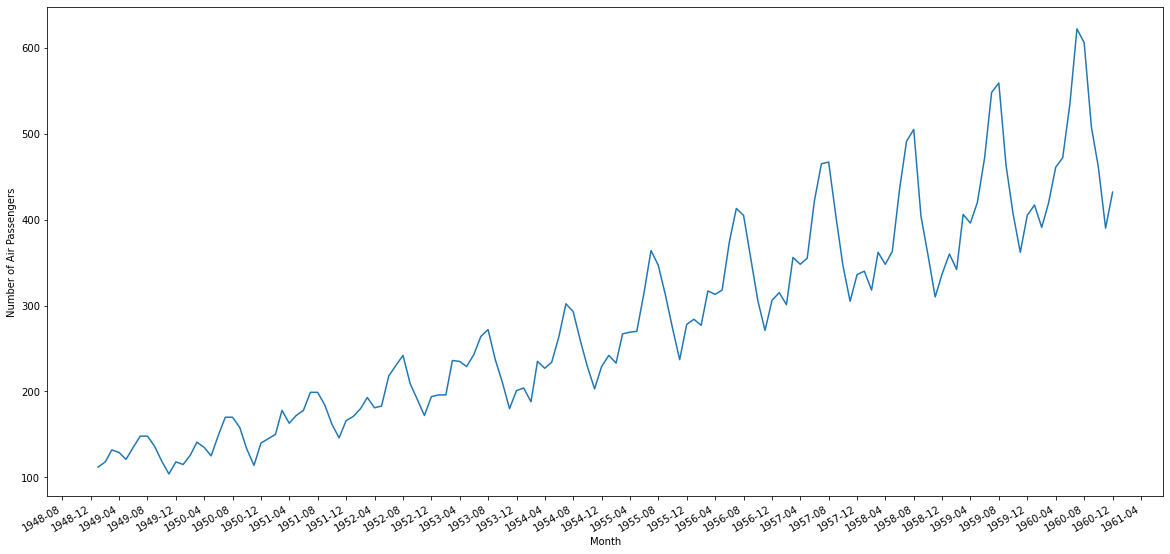

In [31]:
# Time Series plot

fig ,ax = plty.subplots(figsize=(20,10)) # figsize (x,y)
plt.xlabel("Month")
plt.ylabel("Number of Air Passengers")

half_year_locator = mdates.MonthLocator(interval = 4) #Format penanggalan interval 4 bulan 
year_month_formatter = mdates.DateFormatter('%Y-%m')  #Format penanggalan tahun - bulan

ax.xaxis.set_major_locator(half_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter)

ax.plot(df_ap)
fig.autofmt_xdate()
plt.grid(False)
plt.show()

Insights:

Dari grafik di atas, kita dapat melihat bahwa dari data jumlah penumpang memiliki kombinasi yang terdiri dari beberapa pola yaitu tren yang menaik, pola seasonal, dan siklikal selama kurun waktu lebih dari 10 tahun (Jan 1949 s/d Dec 1960).

Pola variasi seasonal dapat ditemukan di setiap bulan Juli.
Lalu kita coba cek menggunakan seasonal plot untuk melihat lebih jelas melalui bantuan package seaborn dan membuat dataframe sementara (variabel: data2) untuk membuat visualisasi seasonal plot.

In [35]:
x = ['month']
y = ['year']

# Seasonal plot 

data2 = df_ap.reset_index()
data2['year'] = pd.DatetimeIndex(data2['Month']).year
data2['month'] = pd.DatetimeIndex(data2['Month']).month


STATIONARITY CHECK - Rolling Statistic test

Rolling ini sangat berguna pada data time series. Secara konsep, rolling artinya membuat rolling window dengan ukuran yang spesifik dan akan melakukan kalkulasi pada data dalam window tsb, yang kemudian akan bergeser terus kebawah seperti yang ditunjukkan pada gambar di bawah.

In [37]:
# rolling dengan interval window sebesar 12 bulan dan hitung rata-rata
rolmean=df_ap.rolling(window=12).mean()  

# rolling dengan interval window sebesar 12 bulan dan hitung st. deviasi
rolstd=df_ap.rolling(window=12).std() 

# Tampilkan 15 baris pertama dari hasil rolling mean
print('15 baris pertama rolling mean: ')
print(rolmean.head(15))                
print ('')

# Tampilkan 15 baris pertama dari hasil rolling st. deviasi
print('15 baris pertama std. deviasi: ')
print(rolstd.head(15))            

15 baris pertama rolling mean: 
            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
1949-06-01          NaN
1949-07-01          NaN
1949-08-01          NaN
1949-09-01          NaN
1949-10-01          NaN
1949-11-01          NaN
1949-12-01   126.666667
1950-01-01   126.916667
1950-02-01   127.583333
1950-03-01   128.333333

15 baris pertama std. deviasi: 
            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
1949-06-01          NaN
1949-07-01          NaN
1949-08-01          NaN
1949-09-01          NaN
1949-10-01          NaN
1949-11-01          NaN
1949-12-01    13.720147
1950-01-01    13.453342
1950-02-01    13.166475
1950-03-01    13.686977


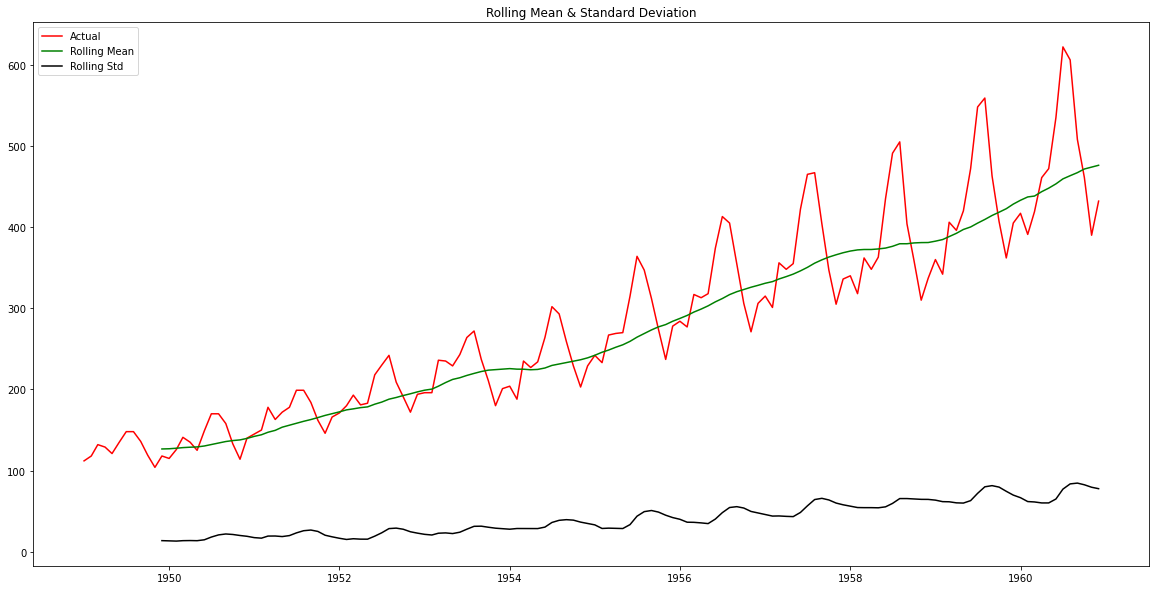

In [38]:
# atur ukuran chart
plt.figure(figsize=(20,10))

# buat multiple line chart berdasarkan warna dan label
actual=plt.plot(df_ap, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')

# tampilkan legend, judul dari chart, dan panggil function untuk menampilkan chart
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Dari grafik di atas kita dapat melihat bahwa data aktual dan rolling (mean dan std) memiliki bentuk yang cukup berbeda, menandakan bahwa series ini tidak stasioner.

Stationarity Check - Augmented Dickey-Fuller (ADF) test

Selanjutnya, kita akan gunakan ADF test untuk uji stasioner dimana:

H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

H1: The time series is stationary.
Jika p-value test kurang dari significance level (contoh alpha = 0.05) dan nilai ADF test lebih kecil dibandingkan critical values maka kita dapat reject null hypothesis dan dapat menyimpulkan bahwa time series adalah stasioner.
critical values bisa diambil persentase secara acak: ( misal : cv = 1%, 5%, 10%, 50% )

In [39]:
# menggunakan function adfuller() yang diterapkan pada variable #Passengers

print('Dickey-Fuller Test: ')
dftest=adfuller(df_ap['#Passengers'], autolag='AIC')
dftest

Dickey-Fuller Test: 


(0.8153688792060423,
 0.9918802434376409,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.6929308390189)

In [40]:
# Supaya hasil uji lebih nyaman dibaca, maka kita buat series berdasarkan index 
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])

# Gunakan for loop untuk menaruh value dari dictionary dengan function items()
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print('Dickey-Fuller Test: ')
print(dfoutput)

# test statistics = ADF test

Dickey-Fuller Test: 
Test Statistic            0.815369
p-value                   0.991880
Lags Used                13.000000
No. of Obs              130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


Insights:

Nilai ADF statistic yang jauh lebih besar dari critical values pada semua level, dan juga p-value yang lebih besar dari 0.05 turut menandakan, kita gagal menolak null hypothesis pada 90%, 95%, dan 99% tingkat keyakinan, yang mengindikasikan bahwa data time series ini strongly non-stationary.

Berdasarkan insights di atas, maka kita akan mencoba menstabilkan variance dengan cara log transformation pada data AirPassenger dengan np.log()

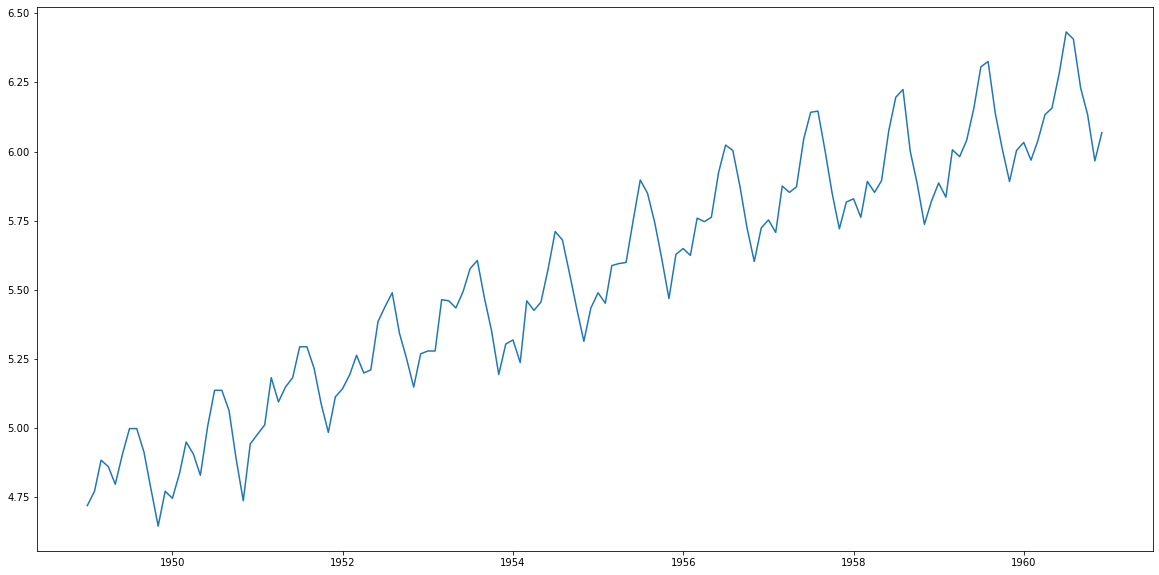

In [41]:
# Plot dalam bentuk visualisasi line chart dengan menggunakan function numpy np.log
plt.figure(figsize=(20,10))
data_log=np.log(df_ap) 
plt.plot(data_log)

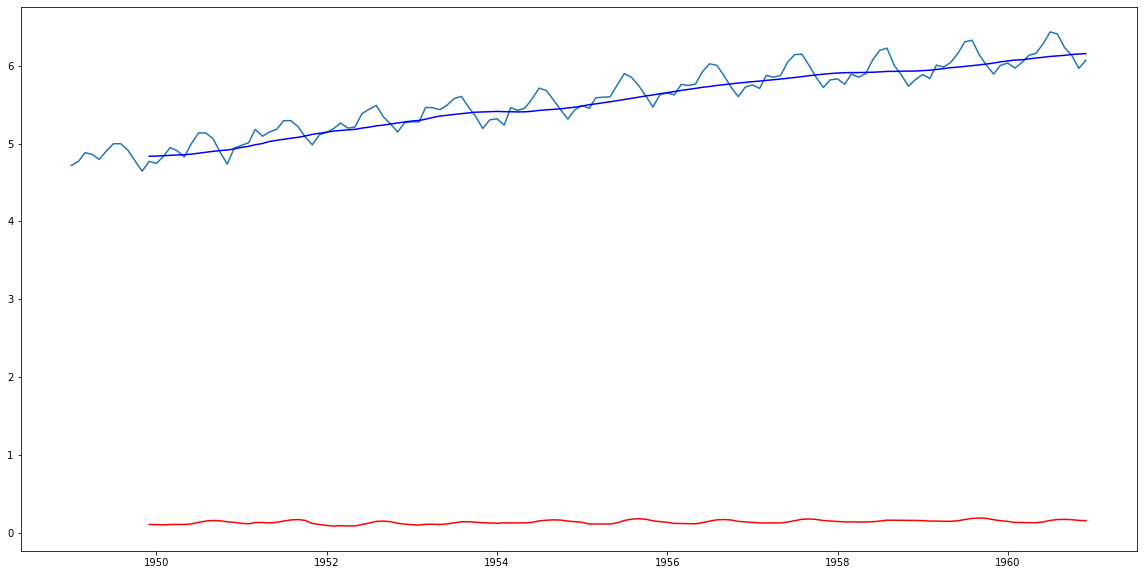

In [42]:
# Cek secara visual kembali dengan plot data_log dengan rolling window mean dan std. deviation
plt.figure(figsize=(20,10))

MAvg=data_log.rolling(window=12).mean() 
MStd=data_log.rolling(window=12).std()

plt.plot(data_log)
plt.plot(MAvg, color='blue')
plt.plot(MStd, color='red')

In [45]:
data_log_diff = data_log-MAvg
data_log_diff . head(12)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


In [46]:
# Efek dari rolling di atas, maka akan ada value NaN, sehingga kita bisa lakukan dropna()
data_log_diff=data_log_diff.dropna() 
data_log_diff.head()

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


In [47]:
data_log_diff.shape

(133, 1)

In [48]:
# Buat function stationarity untuk menampilkan multiple line chart dari actual,rolling mean,rolling std.deviasi
# yang juga berisikan hasil tes dari Dickey-Fuller (Pengujian langsung dengan 2 cara)

def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

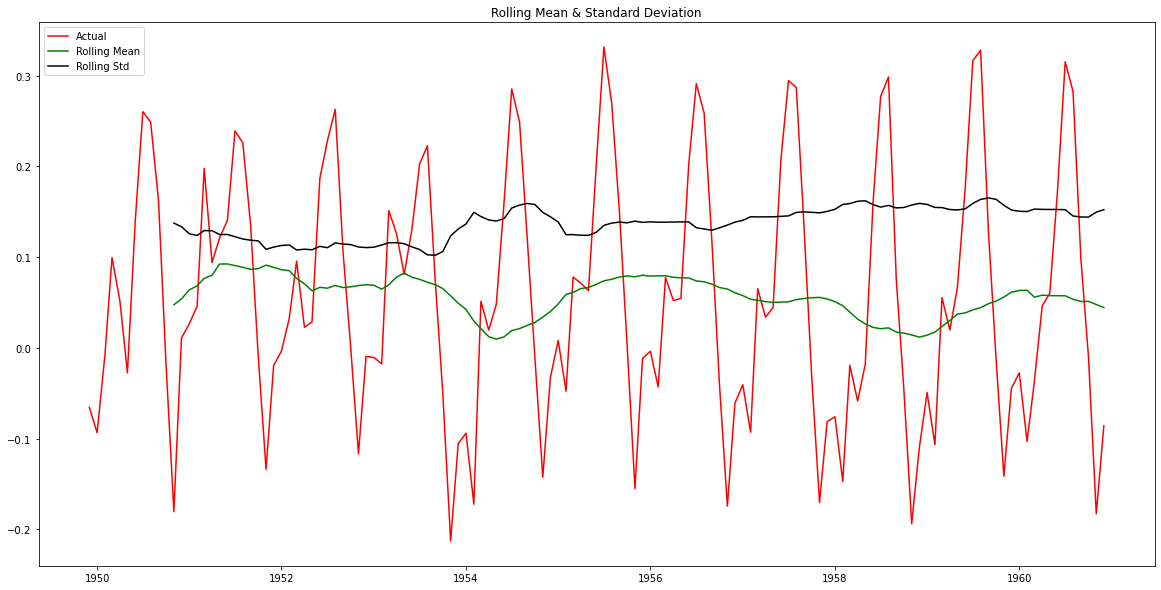

Dickey-Fuller Test: 
Test Statistic           -3.162908
p-value                   0.022235
Lags Used                13.000000
No. of Obs              119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


In [49]:
# panggil function dan terapkan pada data_log_diff
stationarity(data_log_diff)

Insights:

Dapat dilihat dari hasil Dickey-Fuller test ini, bahwa untuk tingkat keyakinan 5% dan 10% sudah menunjukkan series ini stasioner dimana p-value 0.022235 yg < 0.05 menunjukkan bahwa kita menolak null hypothesis (reject to fail H0, accept H1), dan menyatakan bahwa series ini stasioner.

Namun, karena t-value (-3.162908) > DF critical value 1% (-3.486535) maka, kita menerima null hypothesis (H0) yang menyatakan pada series ini tidak stasioner pd tingkat keyakinan 1% (significance level of 0.01).

Maka, kita dapat mencoba lagi dengan menggunakan Exponentially Weighted Moving Average (function ewm), karena melalui EWM kita dapat memberikan lebih banyak bobot kepada observasi terbaru, dengan kata lain dia akan memberikan bobot lebih sedikit terhadap data yang semakin jauh dari waktu kini, sehingga dia dapat menangkap tren terkini secara lebih cepat

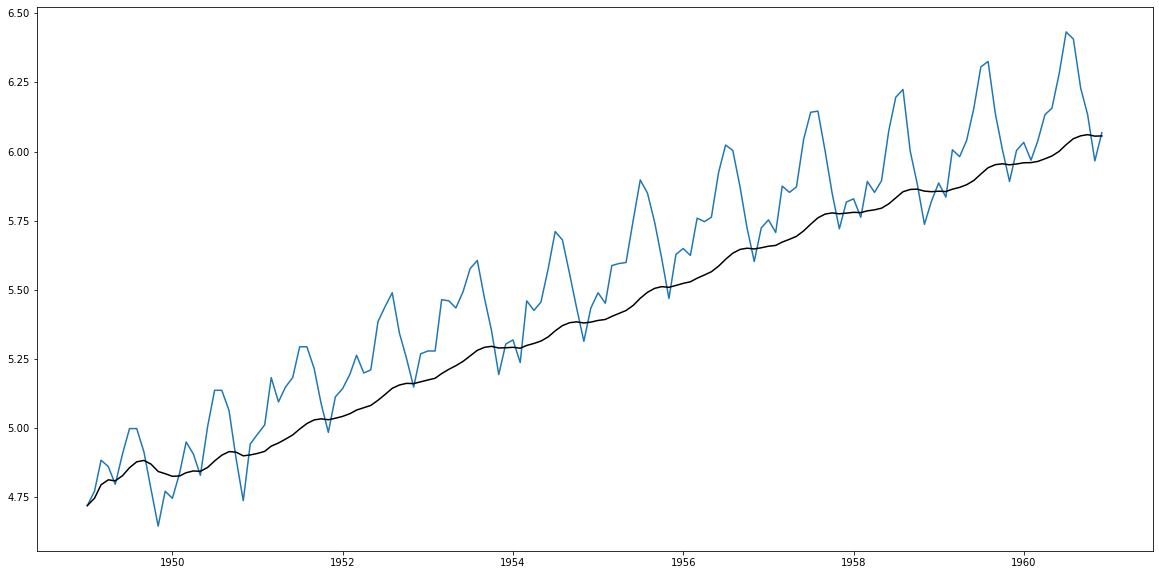

In [50]:
# Visualisasikan ke dalam bentuk chart 
plt.figure(figsize=(20,10))

# Terapkan function ewm pada data_log melalui variable exp_data
exp_data=data_log.ewm(halflife=12, min_periods=0, adjust=True).mean() 

plt.plot(data_log)
plt.plot(exp_data, color='black')

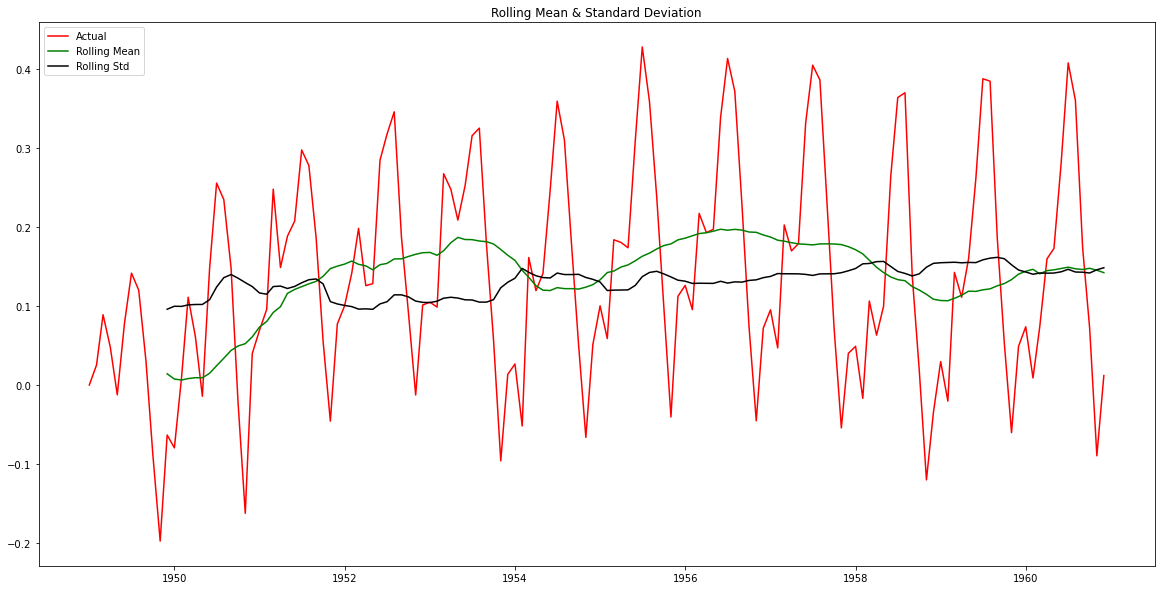

Dickey-Fuller Test: 
Test Statistic           -3.601262
p-value                   0.005737
Lags Used                13.000000
No. of Obs              130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [51]:
# Hitung difference antara data_log dengan exp_data
exp_data_diff=data_log-exp_data

# Panggil function stationarity dan terapkan pada exp_data_diff
stationarity(exp_data_diff)

Insights :

Sekarang, kita dapat melihat hasil melalui Dickey-Fuller test ini bahwa nilai t-value (-3.601262) < DF critical value 1% (-3.481682) maka kita dapat reject null hypothesis, dengan 90%, 95%, dan 99% tingkat keyakinan menyatakan bahwa series ini sudah stasioner.

Stationarity Check - Shift test

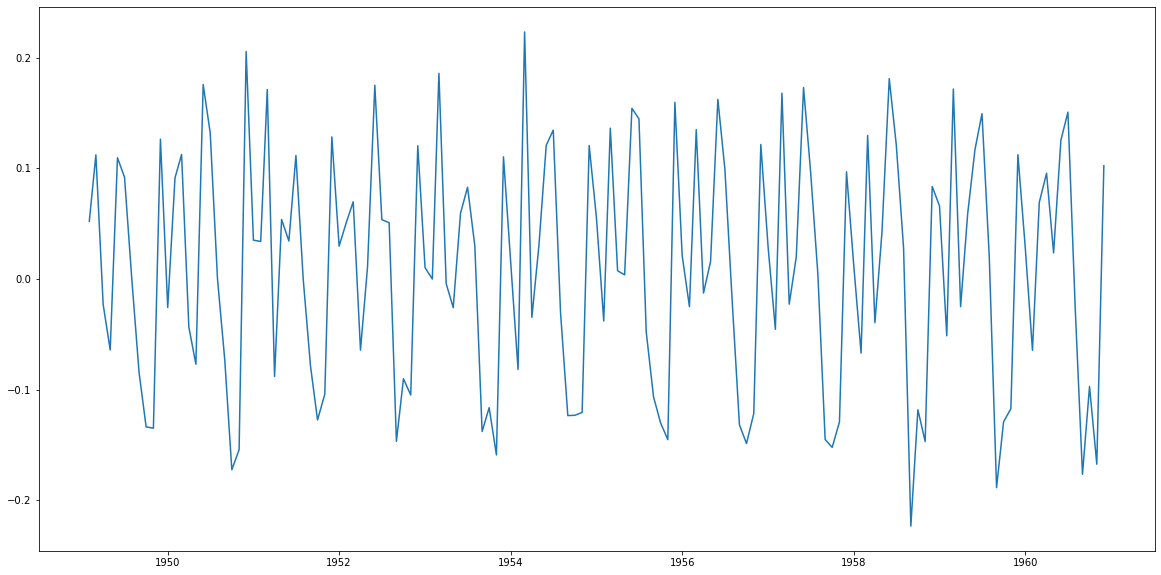

In [54]:
# Buat format ukuran chart
plt.figure(figsize=(20,10))

# Terapkan shift terhadap data yang telah diterapkan transformasi log di cell sebelumnya
data_shift=data_log-data_log.shift() 

# Tampilkan chart
plt.plot(data_shift)

In [55]:
# Check missing value
data_shift.isna().sum()

#Passengers    1
dtype: int64

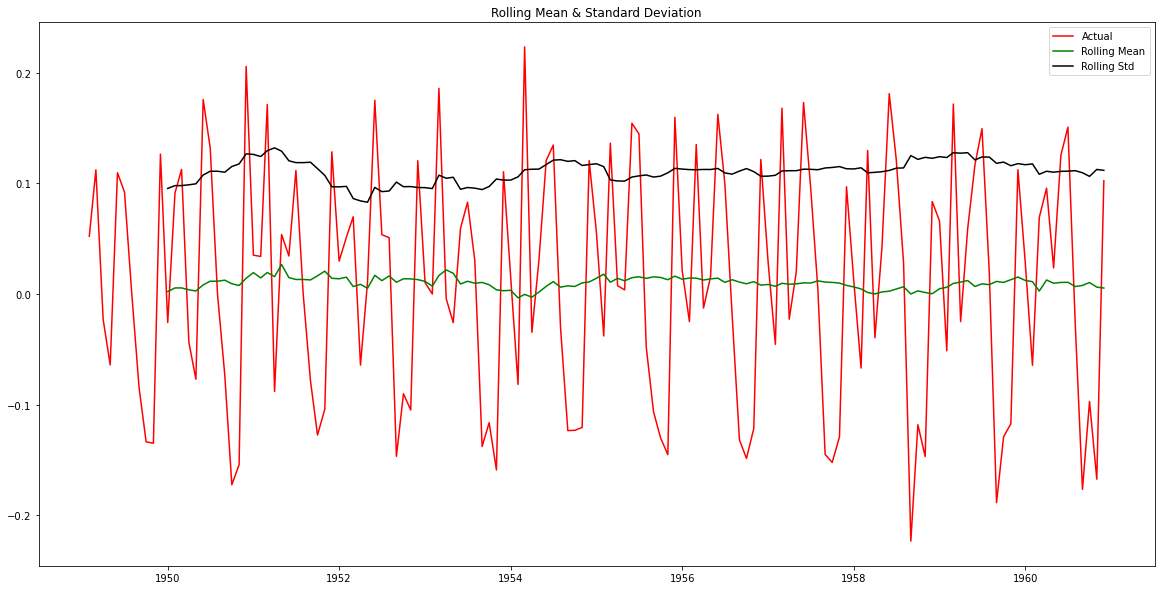

Dickey-Fuller Test: 
Test Statistic           -2.717131
p-value                   0.071121
Lags Used                14.000000
No. of Obs              128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64


In [56]:
# Lakukan dropna 
data_shift=data_shift.dropna()

# Panggil function stationarity dan terapkan pada data_shift yang sudah dibersihkan dari NA value
stationarity(data_shift)

Decomposition and Autocorrelation Function

Forecasting menggunakan data historikal dimana diurutkan dengan waktu, sehingga goal dari time series model yaitu untuk menemukan waktu dengan trend, seasonality, dan autocorrelation (correlation over time) lalu diformulasikan menjadi sebuah model.

Teknik Decomposition ini digunakan untuk split data time series menjadi beberapa komponen yaitu trend, seasonality, dan noise (residual) components.

Setiap komponen dapat digunakan untuk menunjukkan pola (pattern) yang ada di dalam tiap kategori agar dapat menentukan apakah model Additive atau Multiplicative.

Seasonality: describes the periodic signal in your time series.

Trend: describes whether the time series is decreasing, constant, or increasing over time.

Noise: describes what remains behind the separation of seasonality and trend from the time series. In other words, it’s the variability in the data that cannot be explained by the model.

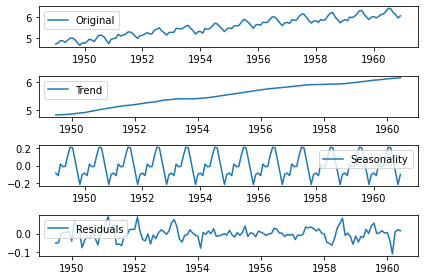

In [57]:
# panggil function seasonal_decompose () dari statsmodels.tsa yang diterapkan di variabel data_log
decomp=seasonal_decompose(data_log)

# buat variabel trend, seasonal, residual yang sudah diterapkan
trend=decomp.trend
seasonal=decomp.seasonal
residual=decomp.resid

# Format gambar 
plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Insights:

Dari proses seasonal decompose, maka akan terbagi menjadi grafik original, trend (dalam hal ini dengan pola menaik), Seasonality (pola berulang yang terjadi dari tahun ke tahun), dan residuals (seberapa jauh titik data dari garis regresi) dan dapat dilihat bahwa trend dari time series AirPassenger adalah semakin menaik, dan seasonality mengikuti pola.


In [58]:
# Tampilkan nilai dari tiap kategori dari 24 baris teratas
print("Trend \n",trend.head(24), '\n') # \n untuk menambahkan baris di akhir
print("Seasonal \n",seasonal.head(24), '\n')
print("Residual \n",residual.head(24), '\n')

Trend 
 Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01    4.837280
1949-08-01    4.841114
1949-09-01    4.846596
1949-10-01    4.851238
1949-11-01    4.854488
1949-12-01    4.859954
1950-01-01    4.869840
1950-02-01    4.881389
1950-03-01    4.893411
1950-04-01    4.904293
1950-05-01    4.912752
1950-06-01    4.923701
1950-07-01    4.940483
1950-08-01    4.957406
1950-09-01    4.974380
1950-10-01    4.991942
1950-11-01    5.013095
1950-12-01    5.033804
Name: trend, dtype: float64 

Seasonal 
 Month
1949-01-01   -0.085815
1949-02-01   -0.114413
1949-03-01    0.018113
1949-04-01   -0.013046
1949-05-01   -0.008966
1949-06-01    0.115393
1949-07-01    0.210816
1949-08-01    0.204512
1949-09-01    0.064836
1949-10-01   -0.075271
1949-11-01   -0.215846
1949-12-01   -0.100315
1950-01-01   -0.085815
1950-02-01   -0.114413
1950-03-01    0.018113
1950-04-01   -0.013046
1950-05-01   -0.008

Insights:
Dari data residual, kita dapat melihat banyak NA value, maka kita lakukan dropna

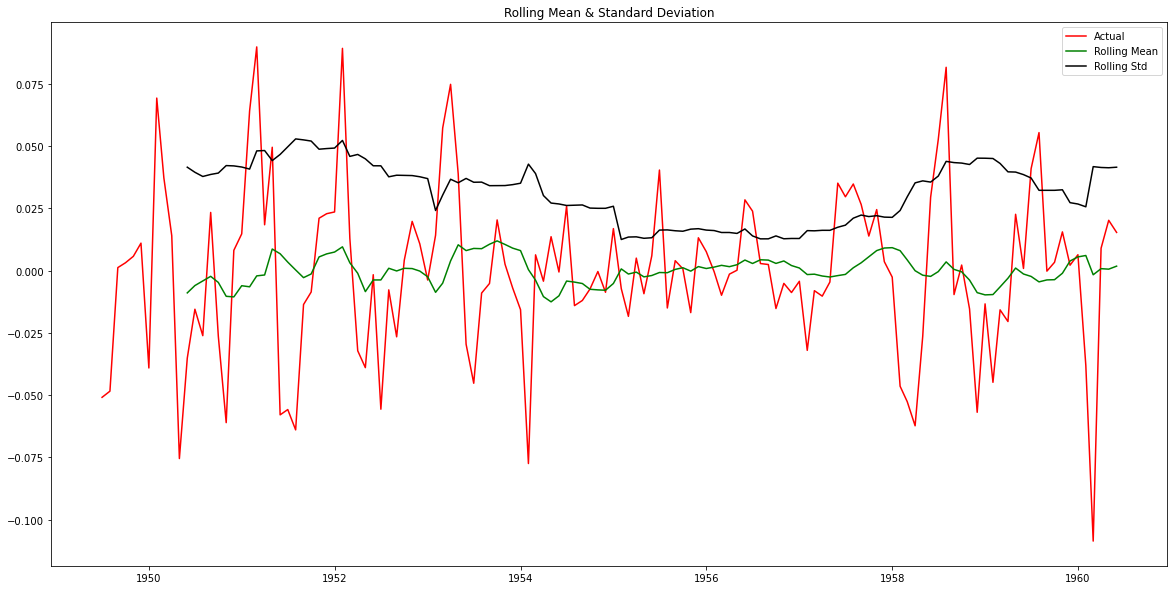

Dickey-Fuller Test: 


KeyError: '#Passengers'

In [60]:
# assign variable baru decomp_data dengan variabel residual di atas
decomp_data=residual

# terapkan function dropna
decomp_data=decomp_data.dropna()

# Panggil function stationarity dan terapkan pada decomp data yang tanpa NA value
stationarity(decomp_data)

Insights:

Dari komponen data residual, hasil ADF test menunjukkan bahwa bahwa nilai Test statistic yg jauh lebih kecil daripada critical value pd berbagai tingkat keyakinan. Dan p-value yang jauh lebih kecil dari 0.05, kita dapat menyatakan bahwa series ini cukup kuat stasioner.

Jika dalam Uji Stasionaritas ada beberapa param, maka dapat dilihat urutannya sbb:
1. ADF Test & Critical Values
2. P-Values & Sig. Level

Autocorrelation Function (ACF) dan Partial Autocorrelation Function (PACF)

Selanjutnya cara lain untuk melakukan tes stasioner adalah dengan menggunakan ACF dan PACF.

Masih ingat dengan konsep sederhana Correlation yang sudah kita dipelajari di topik Statistik sebelummnya? Kedua function berdasarkan konsep dari Correlation.

ACF merupakan korelasi antar data di dalam time series tersebut yang dipisahkan dalam lag dimana (Xt , Xk+t) dengan k adalah jumlah lag dan t adalah nilainya.

Sama halnya dengan ACF, PACF juga menghitung korelasi antar data di time series. Perbedaannya, PACF juga menghitung korelasi antara Xt dan Xt+k namun sebelumnya menghilangkan data antara Xt dan Xt+k terlebih dahulu. Berarti data yang dihilangkan adalah data Xt+1 sampai dengan Xt+k-1

Text(0.5, 1.0, 'Partial Autocorrelation Function / PACF')

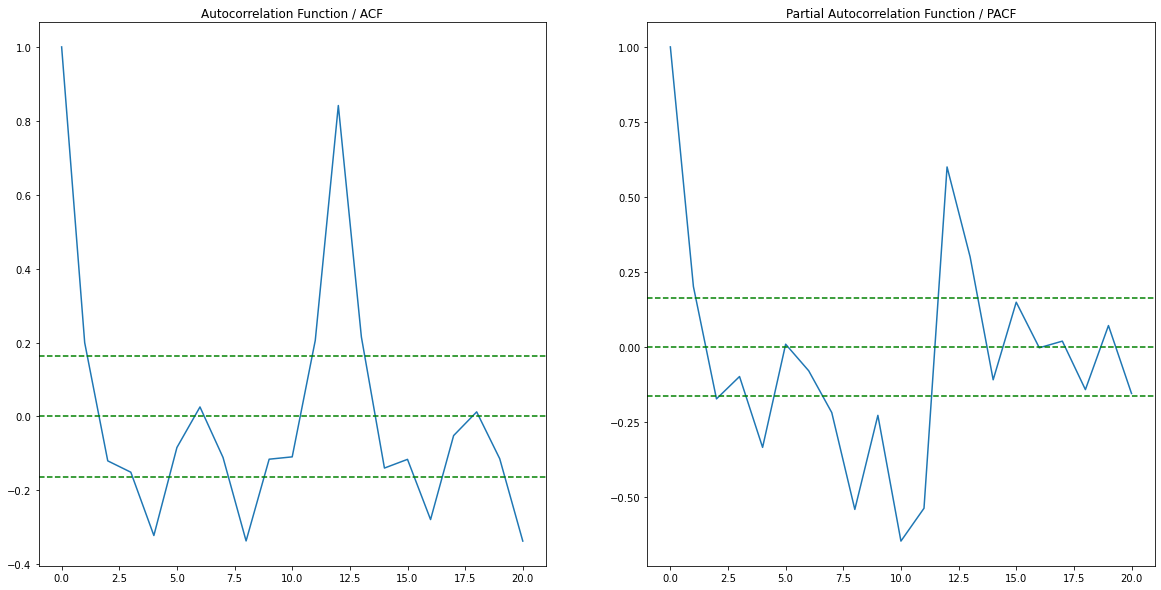

In [61]:
# dari module time series analysis, import function acf dan pacf
# ACF = Auto Correlation Function
# PACF = Partial Auto Correlation Function
from statsmodels.tsa.stattools import acf, pacf 

# terapkan function acf dan pacf pada data_shift yang sudah dibuat
lag_acf=acf(data_shift, nlags=20)
lag_pacf=pacf(data_shift, nlags=20, method='ols')

# Format grafik dan visualisasikan ACF
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(data_shift)),linestyle='--',color='green') # y = -0.16
plt.axhline(y=1.96/np.sqrt(len(data_shift)),linestyle='--',color='green') # y = 0.16
plt.title('Autocorrelation Function / ACF')

# Format grafik dan visualisasikan PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(data_shift)),linestyle='--',color='green') # y = -0.16
plt.axhline(y=1.96/np.sqrt(len(data_shift)),linestyle='--',color='green') # y = 0.16
plt.title('Partial Autocorrelation Function / PACF')

Interpretation:

Fungsi ACF dan PCF membantu kita dengan melakukan plot korelasi antara time series dan lag series tsb dengan 95% tingkat keyakinan ditandai dengan garis hijau putus-putus.

Jika nilai autocorrelation memotong/melewati garis putus-putus tersebut dapat diartikan bahwa specific lag tsb berkorelasi secara signifikan dengan time series yang ada.

Dari grafik di atas terlihat bahwa grafik time series (berwarna biru) berpotongan dengan grafik shift time series (dlm hal ini dengan lag=20) baik pada batas atas maupun bawah, sehingga dapat dikatakan bahwa grafik time series ini mengalami efek auto correlation.